Setting and importing necessary library

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.5.1+cu121
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import torch
from torch_geometric.data import HeteroData
import numpy as np

In [ ]:
# Load datasets
users = pd.read_csv('/content/drive/MyDrive/BIGDATA/Data/ml-1m/users.dat', sep='::', header=None, engine='python',
                    names=['user_id', 'gender', 'age', 'occupation', 'zip_code'])
movies = pd.read_csv('/content/drive/MyDrive/BIGDATA/Data/ml-1m/movies.dat', sep='::', header=None, engine='python',
                     names=['movie_id', 'title', 'genres'], encoding='latin1')
ratings = pd.read_csv('/content/drive/MyDrive/BIGDATA/Data/ml-1m/ratings.dat', sep='::', header=None, engine='python',
                      names=['user_id', 'movie_id', 'rating', 'timestamp'])

In [ ]:
users

,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


In [ ]:
movies

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [ ]:
ratings

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [ ]:
users.describe()

,user_id,age,occupation
count,6040.000000,6040.000000,6040.000000
mean,3020.500000,30.639238,8.146854
std,1743.742145,12.895962,6.329511
min,1.000000,1.000000,0.000000
25%,1510.750000,25.000000,3.000000
50%,3020.500000,25.000000,7.000000
75%,4530.250000,35.000000,14.000000
max,6040.000000,56.000000,20.000000


In [ ]:
movies.describe()

,movie_id
count,3883.000000
mean,1986.049446
std,1146.778349
min,1.000000
25%,982.500000
50%,2010.000000
75%,2980.500000
max,3952.000000


In [ ]:
ratings.describe()

,user_id,movie_id,rating,timestamp
count,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865540e+03,3.581564e+00,9.722437e+08
std,1.728413e+03,1.096041e+03,1.117102e+00,1.215256e+07
min,1.000000e+00,1.000000e+00,1.000000e+00,9.567039e+08
25%,1.506000e+03,1.030000e+03,3.000000e+00,9.653026e+08
50%,3.070000e+03,1.835000e+03,4.000000e+00,9.730180e+08
75%,4.476000e+03,2.770000e+03,4.000000e+00,9.752209e+08
max,6.040000e+03,3.952000e+03,5.000000e+00,1.046455e+09


# Preprocessing

In [ ]:
len(np.unique(users['user_id'])) == len(users['user_id'])

In [ ]:
len(np.unique(movies['movie_id'])) == len(movies['movie_id'])

In [ ]:
len(np.unique(ratings['movie_id'])) < len(np.unique(movies['movie_id']))

In [ ]:
len(np.unique(ratings['user_id'])) == len(np.unique(users['user_id']))

In [ ]:
# Encode gender as numerical
users['gender'] = users['gender'].apply(lambda x: 1 if x == 'M' else 0)

In [ ]:
# Encode genres using one-hot encoding
all_genres = set(g for genres in movies['genres'].str.split('|') for g in genres)
for genre in all_genres:
    movies[genre] = movies['genres'].apply(lambda x: int(genre in x.split('|')))
movies = movies.drop('genres', axis=1)

In [ ]:
# Mapping of user IDs to consecutive values
unique_user_id = users['user_id'].unique()

unique_user_id = pd.DataFrame(data={
    'userId': unique_user_id,
    'mappedID': pd.RangeIndex(len(unique_user_id)),
})
unique_user_id.head()

,userId,mappedID
0,1,0
1,2,1
2,3,2
3,4,3
4,5,4


In [ ]:
# Mapping of movie IDs to consecutive values
unique_movie_id = movies['movie_id'].unique()

unique_movie_id = pd.DataFrame(data={
    'movieId': unique_movie_id,
    'mappedID': pd.RangeIndex(len(unique_movie_id)),
})
unique_movie_id.head()

,movieId,mappedID
0,1,0
1,2,1
2,3,2
3,4,3
4,5,4


## Graph Transfrom

In [ ]:
import torch
from torch_geometric.data import HeteroData
from torch_geometric.utils import to_undirected
import torch_geometric.transforms as T

In [ ]:
data = HeteroData()

In [ ]:
data["user"].node_id = torch.arange(len(unique_user_id))
data["movie"].node_id = torch.arange(len(movies))

In [ ]:
# Chuẩn bị dữ liệu người dùng (user nodes)
user_features = torch.tensor(users[['gender', 'age', 'occupation']].values, dtype=torch.float)
data['user'].x = user_features

# Chuẩn bị dữ liệu phim (movie nodes)
movie_features = torch.tensor(movies.drop(['title', 'movie_id'], axis=1).values, dtype=torch.float)
data['movie'].x = movie_features

In [ ]:
# Tạo edges dựa trên ratings
merged_user = ratings.merge(unique_user_id, left_on='user_id', right_on='userId', how='left')
merged_movie = ratings.merge(unique_movie_id, left_on='movie_id', right_on='movieId', how='left')
ratings_user_id = torch.from_numpy(merged_user['mappedID'].values)
ratings_movie_id = torch.from_numpy(merged_movie['mappedID'].values)
edge_index = torch.stack([ratings_user_id, ratings_movie_id], dim=0)
# edge_index = torch.tensor([ratings['user_id'].values - 1, ratings['movie_id'].values - 1], dtype=torch.long)

data['user', 'rates', 'movie'].edge_index = edge_index
# data['user', 'rates', 'movie'].edge_label = torch.from_numpy(ratings['rating'].values).to(torch.float)

In [ ]:
# Tạo trọng số cho các cạnh (dùng rating làm trọng số)
edge_weight = torch.tensor(ratings['rating'].values, dtype=torch.float)
data['user', 'rates', 'movie'].edge_attr = edge_weight  # Gắn trọng số vào các cạnh

In [ ]:
data = T.ToUndirected()(data)
data

HeteroData(
  user={
    node_id=[6040],
    x=[6040, 3],
  },
  movie={
    node_id=[3883],
    x=[3883, 18],
  },
  (user, rates, movie)={
    edge_index=[2, 1000209],
    edge_attr=[1000209],
  },
  (movie, rev_rates, user)={
    edge_index=[2, 1000209],
    edge_attr=[1000209],
  }
)

Train test split

In [ ]:
data["user", "rates", "movie"]['x_dict'] = data.x_dict

In [ ]:
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.2,        # 20% dữ liệu cho validation
    num_test=0.0,       # 0% dữ liệu cho test
    disjoint_train_ratio=0.3,  # Tỷ lệ tập huấn luyện không chồng lấp với validation/test
    add_negative_train_samples=False,  # Tạo mẫu âm cho tập huấn luyện
    edge_types=("user", "rates", "movie"),  # Loại liên kết
    rev_edge_types=("movie", "rev_rates", "user"),  # Các liên kết nghịch đảo
)(data)
train_data, val_data, test_data

(HeteroData(
   user={
     node_id=[6040],
     x=[6040, 3],
   },
   movie={
     node_id=[3883],
     x=[3883, 18],
   },
   (user, rates, movie)={
     edge_index=[2, 560118],
     edge_attr=[560118],
     x_dict={
       user=[6040, 3],
       movie=[3883, 18],
     },
     edge_label=[240050],
     edge_label_index=[2, 240050],
   },
   (movie, rev_rates, user)={
     edge_index=[2, 560118],
     edge_attr=[560118],
   }
 ),
 HeteroData(
   user={
     node_id=[6040],
     x=[6040, 3],
   },
   movie={
     node_id=[3883],
     x=[3883, 18],
   },
   (user, rates, movie)={
     edge_index=[2, 800168],
     edge_attr=[800168],
     x_dict={
       user=[6040, 3],
       movie=[3883, 18],
     },
     edge_label=[400082],
     edge_label_index=[2, 400082],
   },
   (movie, rev_rates, user)={
     edge_index=[2, 800168],
     edge_attr=[800168],
   }
 ),
 HeteroData(
   user={
     node_id=[6040],
     x=[6040, 3],
   },
   movie={
     node_id=[3883],
     x=[3883, 18],
   },
   (u

In [ ]:
train_data["user", "rates", "movie"].edge_label

tensor([1., 1., 1.,  ..., 1., 1., 1.])

In [ ]:
val_data["user", "rates", "movie"].edge_label

tensor([1., 1., 1.,  ..., 0., 0., 0.])

In [ ]:
type(train_data["user", "rates", "movie"])

torch_geometric.data.storage.EdgeStorage

In [ ]:
from torch_geometric.loader import LinkNeighborLoader

In [ ]:


# get node id of source and distance
edge_label_index = train_data["user", "rates", "movie"].edge_label_index
edge_label_index.shape

torch.Size([2, 240050])

In [ ]:
# get value of edges
edge_label = train_data["user", "rates", "movie"].edge_label
edge_label

tensor([1., 1., 1.,  ..., 1., 1., 1.])

In [ ]:
train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[20, 10],
    neg_sampling_ratio=2.0,
    edge_label_index=(("user", "rates", "movie"), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=True,
)

/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [ ]:
test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=[20, 10],
    neg_sampling_ratio=2.0,
    edge_label_index=(("user", "rates", "movie"), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=True,
)

# Build GNN

In [ ]:
from torch_geometric.nn import SAGEConv, to_hetero
import torch.nn.functional as F

from torch import Tensor

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

class Classifier(torch.nn.Module):
    def forward(self, x_user: Tensor, x_movie: Tensor, edge_label_index: Tensor) -> Tensor:
        edge_feat_user = x_user[edge_label_index[0]]
        edge_feat_movie = x_movie[edge_label_index[1]]
        return (edge_feat_user * edge_feat_movie).sum(dim=-1)

class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.user_lin = torch.nn.Linear(3, hidden_channels)
        self.movie_lin = torch.nn.Linear(18, hidden_channels)
        self.user_emb = torch.nn.Embedding(data["user"].num_nodes, hidden_channels)
        self.movie_emb = torch.nn.Embedding(data["movie"].num_nodes, hidden_channels)
        self.gnn = GNN(hidden_channels)
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())
        self.classifier = Classifier()
    def forward(self, data: HeteroData) -> Tensor:
        x_dict = {
          "user": self.user_lin(data["user"].x) + self.user_emb(data["user"].node_id),
          "movie": self.movie_lin(data["movie"].x) + self.movie_emb(data["movie"].node_id),
        }
        x_dict = self.gnn(x_dict, data.edge_index_dict)

        if "edge_label_index" in data["user", "rates", "movie"]:
            edge_label_index = data["user", "rates", "movie"].edge_label_index
        else:
            edge_label_index = data["user", "rates", "movie"].edge_index
        pred = self.classifier(
            x_dict["user"],
            x_dict["movie"],
            edge_label_index,
        )
        return pred

model = Model(hidden_channels=64)

In [ ]:
import torch
import torch.nn as nn
import torch_geometric.nn as pyg_nn
from torch_geometric.nn import GCNConv

class GNNRecommendationModel(nn.Module):
    def __init__(self, hidden_dim=64):
        super(GNNRecommendationModel, self).__init__()

        # GCN layers
        self.gcn_user = GCNConv(3, hidden_dim)
        self.gcn_movie = GCNConv(18, hidden_dim)

        # MLP for prediction (output is the predicted rating)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, data):
        # Đặc trưng của người dùng và phim
        user_x = data['user'].x
        movie_x = data['movie'].x

        # Edge indices và edge weights
        edge_index = data['user', 'rates', 'movie'].edge_index
        edge_attr = data['user', 'rates', 'movie'].edge_attr


        # GCN cho người dùng
        user_out = self.gcn_user(user_x, edge_index, edge_attr)
        print("ha")
        # GCN cho phim
        movie_out = self.gcn_movie(movie_x, edge_index, edge_attr)
        print(edge_attr)
        # Ghép đặc trưng người dùng và phim cho mỗi cạnh
        out = torch.cat([user_out, movie_out], dim=-1)

        # Dự đoán rating từ MLP
        rating_pred = self.mlp(out)

        return rating_pred

# Training

In [ ]:
sageconvloss=[]

In [ ]:
import tqdm
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

Device: 'cpu'


In [ ]:
fkprint("Training model with sageconv")
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs=10
for epoch in range(n_epochs):
    total_loss = total_examples = 0
    print(f"Epoch: {epoch+1}",sep='')
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        sampled_data.to(device)
        pred = model(sampled_data)
        ground_truth = sampled_data["user", "rates", "movie"].edge_label
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    print(f"Loss: {total_loss / total_examples:.4f}")
    loss = total_loss / total_examples
    sageconvloss.append(round(loss, 4))

Training model with sageconv
Epoch: 1


100%|██████████| 1876/1876 [06:20<00:00,  4.93it/s]


Loss: 0.3356
Epoch: 2


100%|██████████| 1876/1876 [06:13<00:00,  5.02it/s]


Loss: 0.3241
Epoch: 3


100%|██████████| 1876/1876 [06:15<00:00,  5.00it/s]


Loss: 0.3196
Epoch: 4


100%|██████████| 1876/1876 [06:12<00:00,  5.03it/s]


Loss: 0.3168
Epoch: 5


100%|██████████| 1876/1876 [06:13<00:00,  5.02it/s]


Loss: 0.3140
Epoch: 6


100%|██████████| 1876/1876 [06:14<00:00,  5.01it/s]


Loss: 0.3109
Epoch: 7


100%|██████████| 1876/1876 [06:13<00:00,  5.03it/s]


Loss: 0.3112
Epoch: 8


100%|██████████| 1876/1876 [06:11<00:00,  5.05it/s]


Loss: 0.3091
Epoch: 9


100%|██████████| 1876/1876 [06:10<00:00,  5.06it/s]


Loss: 0.3074
Epoch: 10


100%|██████████| 1876/1876 [06:09<00:00,  5.08it/s]

Loss: 0.3060


In [ ]:
torch.save(model.state_dict(), "model_gnn.pth")

In [ ]:
model = Model(hidden_channels=64)

model.load_state_dict(torch.load("model_gnn.pth", map_location=torch.device('cpu')))
model.eval()

<ipython-input-52-f8041d684be0>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_gnn.pth", map_location=torch.device('cpu')))


Model(
  (user_lin): Linear(in_features=3, out_features=64, bias=True)
  (movie_lin): Linear(in_features=18, out_features=64, bias=True)
  (user_emb): Embedding(6040, 64)
  (movie_emb): Embedding(3883, 64)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (user__rates__movie): SAGEConv(64, 64, aggr=mean)
      (movie__rev_rates__user): SAGEConv(64, 64, aggr=mean)
    )
    (conv2): ModuleDict(
      (user__rates__movie): SAGEConv(64, 64, aggr=mean)
      (movie__rev_rates__user): SAGEConv(64, 64, aggr=mean)
    )
  )
  (classifier): Classifier()
)

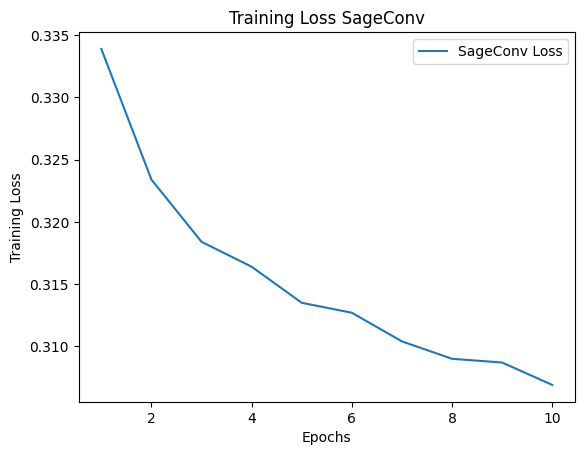

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, 11)
plt.plot(epochs, sageconvloss, label='SageConv Loss')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss SageConv')
plt.legend()
plt.show()

In [ ]:
import torch.optim as optim
import torch.nn.functional as F

# Khởi tạo mô hình
model = GNNRecommendationModel()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Loss function (MSE loss)
def train(model, dataa):
    model.train()
    optimizer.zero_grad()

    # Lấy đầu ra từ mô hình
    rating_pred = model(dataa)

    # Lấy nhãn (ratings thực tế)
    true_ratings = dataa['user', 'rates', 'movie'].edge_attr  # Trọng số cạnh chính là rating thực tế

    # Tính loss
    loss = F.mse_loss(rating_pred.view(-1), true_ratings)

    # Backpropagation
    loss.backward()
    optimizer.step()

    return loss.item()

# Huấn luyện mô hình
for epoch in range(n_epochs):
    total_loss = total_examples = 0
    print(f"Epoch: {epoch+1}",sep='')
    for sampled_data in tqdm.tqdm(train_loader):
      sampled_data.to(device)
      loss = train(model, sampled_data)
      print(f"Loss: {loss:.4f}")

Epoch: 1


  0%|          | 0/1876 [00:00<?, ?it/s]

ha


IndexError: index 2948 is out of bounds for dimension 0 with size 2948

## K-Flod Cross Validation

In [ ]:
from sklearn.model_selection import KFold


def train_and_evaluate_fold(train_data, val_data, model, optimizer, device):
    train_loader = LinkNeighborLoader(
        data=train_data,
        num_neighbors=[20, 10],
        neg_sampling_ratio=2.0,
        edge_label_index=(("user", "rates", "movie"), train_data["user", "rates", "movie"].edge_label_index),
        edge_label=train_data["user", "rates", "movie"].edge_label,
        batch_size=128,
        shuffle=True,
    )


    # Huấn luyện mô hình
    model.train()
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        sampled_data.to(device)
        pred = model(sampled_data)
        ground_truth = sampled_data["user", "rates", "movie"].edge_label
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()

    # Tính toán loss
    loss = total_loss / total_examples
    return loss

In [ ]:
n_folds=10
n_epochs=10
model = model.to(device)
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)
fold_results = []
transfrom = T.RandomLinkSplit(
  num_val=0.1,        # 20% dữ liệu cho validation
  num_test=0.1,       # 0% dữ liệu cho test
  disjoint_train_ratio=0.3,  # Tỷ lệ tập huấn luyện không chồng lấp với validation/test
  add_negative_train_samples=False,  # Tạo mẫu âm cho tập huấn luyện
  edge_types=("user", "rates", "movie"),  # Loại liên kết
  rev_edge_types=("movie", "rev_rates", "user"),  # Các liên kết nghịch đảo
)

for fold, (train_idx, val_idx) in enumerate(kfold.split(data["user"].x)):
    print(f"Fold {fold + 1}/{n_folds}")

    # Tạo dữ liệu cho fold
    train_data = data.clone()
    val_data = data.clone()

    # Chia dữ liệu thành tập huấn luyện và kiểm tra
    train_data["user"].x = data["user"].x[train_idx]
    val_data["user"].x = data["user"].x[val_idx]

    train_data, _, __ = transfrom(train_data)
    val_data, _, __ = transfrom(val_data)
    # print(train_data["user", "rates", "movie"].edge_label.shape)
    # Gọi các hàm tương tự cho movie, edge_index, edge_attr, etc.
    # (Chú ý là bạn phải xử lý lại việc tạo edge_index và edge_attr theo chỉ số mới sau khi chia dữ liệu)

    # Thiết lập lại optimizer cho mỗi fold
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    try:
      e = train_data["user", "rates", "movie"].edge_label_index
      ee = train_data["user", "rates", "movie"].edge_label
      train_loader = LinkNeighborLoader(
        data=train_data,
        num_neighbors=[20, 10],
        neg_sampling_ratio=2.0,
        edge_label_index=(("user", "rates", "movie"), e),
        edge_label=ee,
        batch_size=128,
        shuffle=True,
    )
    except:
      print("Lỗi")


    # Huấn luyện và đánh giá mô hình trên từng fold
#     for epoch in range(n_epochs):
#         train_loss = train_and_evaluate_fold(train_data, val_data, model, optimizer, device)
#         print(f"Epoch {epoch+1}/{n_epochs} - Training loss: {train_loss:.4f}")

#     fold_results.append(train_loss)

# # Tính toán kết quả trung bình và độ lệch chuẩn của các fold
# avg_loss = sum(fold_results) / n_folds
# print(f"Average training loss over {n_folds} folds: {avg_loss:.4f}")

Fold 1/10


# Evaluation

In [ ]:
edge_label_index = val_data["user", "rates", "movie"].edge_label_index
edge_label = val_data["user", "rates", "movie"].edge_label
val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20, 10],
    edge_label_index=(("user", "rates", "movie"), edge_label_index),
    edge_label=edge_label,
    batch_size=3 * 128,
    shuffle=False,
)
sampled_data = next(iter(val_loader))

/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [ ]:
#sage conv
from sklearn.metrics import roc_auc_score
preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        sampled_data.to(device)
        preds.append(model(sampled_data))
        ground_truths.append(sampled_data["user", "rates", "movie"].edge_label)
pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
print(pred)
print(ground_truth)

100%|██████████| 1042/1042 [02:55<00:00,  5.95it/s]

[ -1.1151379   1.30944     1.0067726 ...  -5.278827   -0.9573869
 -15.330432 ]
[1. 1. 1. ... 0. 0. 0.]


In [ ]:
pred_ = pred.flatten()
ground_truth_ = ground_truth.flatten()

In [ ]:
pred_.shape, ground_truth_.shape

((400082,), (400082,))

In [ ]:
np.unique(ground_truth)

array([0., 1.], dtype=float32)

In [ ]:
np.unique(pred)

array([-64.907974 , -51.108414 , -49.454117 , ...,   5.1953344,
         5.273757 ,   5.594146 ], dtype=float32)

In [ ]:
pred.min()

-64.907974

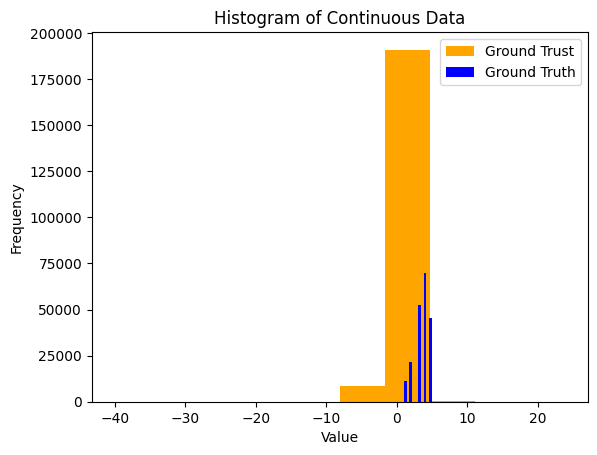

In [ ]:
plt.hist(pred, label='Ground Trust', color='orange')
plt.hist(ground_truth, label='Ground Truth', color='blue')


# Thêm tiêu đề và nhãn
plt.title('Histogram of Continuous Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()


In [ ]:
accuracy = np.mean(pred == ground_truth)
print(f"Validation Accuracy: {accuracy:.4f}")


Validation Accuracy: 0.0000


In [ ]:
auc = roc_auc_score(ground_truth, pred)
print()
print(f"Validation AUC: {auc:.4f}")
sageconvauc=round(auc,4)


Validation AUC: 0.9432


# Inferences

In [ ]:
user_id = int(input('Enter user_id: '))

all_movies = torch.arange(data["movie"].num_nodes)

users = torch.full((data["movie"].num_nodes,), user_id)
print(users)

edge_index_test = torch.stack([users, all_movies], dim=0)
print(len(edge_index_test[0]))
edge_index_user_to_movie = torch.stack([ratings_user_id, ratings_movie_id], dim=0)
original_user_edges = edge_index_user_to_movie[:, edge_index_user_to_movie[0] == user_id]
original_user_edges_set = set(tuple(edge) for edge in original_user_edges.t().tolist())
mask = [tuple(edge) not in original_user_edges_set for edge in edge_index_test.t().tolist()]
edge_index_test = edge_index_test[:, mask]
print(len(edge_index_test[0]))


test_data = HeteroData()


test_data["user"].node_id = torch.arange(len(unique_user_id))
test_data["movie"].node_id = torch.arange(len(movies))

test_data["user", "rates", "movie"].edge_index = edge_index_test
test_data["user"].x = user_features
test_data["movie"].x = movie_features
test_data = T.ToUndirected()(test_data)
print(test_data["user", "rates", "movie"].edge_index)

model.eval()
with torch.no_grad():
    pred_test = model(test_data)
print(pred_test.shape)
# max_rating_index = pred_test.argmax()
_, top_k_movie_indices = torch.topk(pred_test, 10)
recommended_movie = all_movies[top_k_movie_indices]

print(f"The recommended movie for user {user_id} is movie {recommended_movie}.")


Enter user_id: 10
tensor([10, 10, 10,  ..., 10, 10, 10])
3883
tensor([[  10, 1700],
        [  10, 1636],
        [  10,  214],
        [  10, 2928],
        [  10, 1239],
        [  10, 1171],
        [  10, 2637],
        [  10,  582],
        [  10,  583],
        [  10, 2570],
        [  10, 2067],
        [  10, 1245],
        [  10, 2641],
        [  10,  657],
        [  10,  586],
        [  10, 1179],
        [  10, 2643],
        [  10, 1180],
        [  10,  589],
        [  10, 1847],
        [  10,  593],
        [  10, 3379],
        [  10,  228],
        [  10, 1720],
        [  10, 2007],
        [  10, 1258],
        [  10, 1854],
        [  10, 2511],
        [  10, 1726],
        [  10,  315],
        [  10,  243],
        [  10,  246],
        [  10, 1337],
        [  10, 1268],
        [  10, 2735],
        [  10, 3539],
        [  10, 2737],
        [  10, 3327],
        [  10, 3032],
        [  10, 2529],
        [  10, 2233],
        [  10, 3036],
        [  10,

# Visualize

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

movies_subset = movies.iloc[1:,0].head(25).tolist()
movies_subset = [int(movie_id) for movie_id in movies_subset]
users_subset = ratings['user_id'].head(25).tolist()
ratings_subset = ratings[(ratings['movie_id'].isin(movies_subset)) & (ratings['user_id'].isin(users_subset))]
users_with_most_ratings = ratings['user_id'].value_counts().head(25).index.tolist()
ratings_subset = ratings[(ratings['movie_id'].isin(movies_subset)) & (ratings['user_id'].isin(users_with_most_ratings))]

B = nx.Graph()

B.add_nodes_from(movies_subset, bipartite=0)
B.add_nodes_from(users_with_most_ratings, bipartite=1)

for _, row in ratings_subset.iterrows():
    B.add_edge(row['user_id'], row['movie_id'])

node_colors = ['skyblue' if n in movies_subset else 'lightgreen' for n in B.nodes]

plt.figure(figsize=(12, 8))
pos = nx.bipartite_layout(B, nodes=movies_subset)
nx.draw(B, pos, node_size=300, with_labels=True, font_size=8, node_color=node_colors, alpha=0.8, font_color='black', edge_color='gray')
plt.title("Bipartite Graph for a Subset of movielens dataset")
plt.show()

In [ ]:
import networkx as nx
import random
import matplotlib.pyplot as plt

num_users_to_sample = 1
sampled_user_ids = [200]
print(sampled_user_ids)
sampled_edge_indices = edge_index_user_to_movie[:, ratings['user_id'] == sampled_user_ids[0]]
G = nx.DiGraph()
G.add_node("User", label="User")
for movie_id in sampled_edge_indices[1].unique():
    G.add_node(movie_id.item(), label="Movie")
for movie_id in sampled_edge_indices[1]:
    G.add_edge("User", movie_id.item())

user_id = sampled_user_ids[0]
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1000, font_size=10, node_color='skyblue', alpha=0.8)
plt.title("User-Movie Interaction Graph for 1 User with User ID: " + str(user_id))  # Concatenate the string and user_id
plt.show()